# Using AI privacy dataset assessment

In this tutorial we will show how to perform privacy risk analysis of synthetic datasets for ML models using the dataset assessment module.

This will be demonstrated using the Nursery dataset (original dataset can be found here: https://archive.ics.uci.edu/ml/datasets/nursery).

The method `get_nursery_dataset_pd()` preprocesses the data such that all categorical features are one-hot encoded, and all the features are scaled.

## Load data
Load the nursery dataset with preprocessing and divided into a training and a test (holdout) dataset.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
from apt.utils.dataset_utils import get_nursery_dataset_pd

(x_train, y_train), (x_test, y_test) = get_nursery_dataset_pd(raw=False)

### A simplistic synthetic data generator
We are using here a simple synthetic data generator just for testing purposes.

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import numpy as np


def kde(n_samples, n_components, original_data):
    """
    Simple synthetic data generator: estimates the kernel density of data using a Gaussian kernel and then generates
    samples from this distribution
    """
    digit_data = original_data
    pca = PCA(n_components=n_components, whiten=False)
    data = pca.fit_transform(digit_data)
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(), params, cv=5)
    grid.fit(data)

    kde_estimator = grid.best_estimator_

    new_data = kde_estimator.sample(n_samples, random_state=0)
    new_data = pca.inverse_transform(new_data)
    return new_data

Generate synthetic data based on the training data provided using the above simple synthetic data generator.

In [4]:
from apt.utils.datasets import ArrayDataset

NUM_SYNTH_SAMPLES = 1000
num_synth_components = 4
synthetic_data = ArrayDataset(
    kde(NUM_SYNTH_SAMPLES, n_components=num_synth_components, original_data=x_train))
original_data_members = ArrayDataset(x_train, y_train)
original_data_non_members = ArrayDataset(x_test, y_test)

## Run dataset assessment attacks using the DatasetAssessmentManager
Run all the dataset assessment attacks and get all their scores.

In [5]:
from apt.risk.data_assessment.dataset_assessment_manager import DatasetAssessmentManager

mgr = DatasetAssessmentManager()
[score_g, score_h] = mgr.assess(original_data_members, original_data_non_members, synthetic_data)

You can look at the detailed scores of all the attacks:

In [6]:
[score_g, score_h]

[DatasetAttackScoreMembershipKnnProbabilities(dataset_name='dataset', risk_score=0.5240037704709084, result=DatasetAttackResultMembership(member_probabilities=array([0.01007556, 0.0275953 , 0.00927414, ..., 0.02032066, 0.02422755,
        0.01936171]), non_member_probabilities=array([0.01604541, 0.01468508, 0.02964371, ..., 0.01211544, 0.02528228,
        0.01123632])), roc_auc_score=0.5240037704709084, average_precision_score=0.8113983279052946, assessment_type='MembershipKnnProbabilities'),
 DatasetAttackScoreWholeDatasetKnnDistance(dataset_name='dataset', risk_score=0.755, result=None, share=0.755, assessment_type='WholeDatasetKnnDistance')]

Or you can look at only the privacy risk scores of all the attacks:

In [7]:
[score_g.risk_score, score_h.risk_score]

[0.5240037704709084, 0.755]

## Run dataset assessment attacks directly

### DatasetAttackMembershipKnnProbabilities
Run the privacy risk assessment for synthetic datasets based on Black-Box MIA attack using distances of
members (training set) and non-members (holdout set) from their nearest neighbors in the synthetic dataset.
The area under the receiver operating characteristic curve (AUC ROC) gives the privacy risk measure.
The ROC curve is displayed and saved in a file `nursery_kde_roc_curve.png`.

100%|██████████| 259/259 [00:00<00:00, 1788.85it/s]


DatasetAttackScoreMembershipKnnProbabilities(dataset_name='nursery_kde', risk_score=0.5239885362472235, result=DatasetAttackResultMembership(member_probabilities=array([0.01007556, 0.0275953 , 0.00927414, ..., 0.00916724, 0.02177538,
       0.01577258]), non_member_probabilities=array([0.01604541, 0.01468508, 0.02964371, ..., 0.02463582, 0.03069304,
       0.01211544])), roc_auc_score=0.5239885362472235, average_precision_score=0.8114761156597142, assessment_type='MembershipKnnProbabilities')

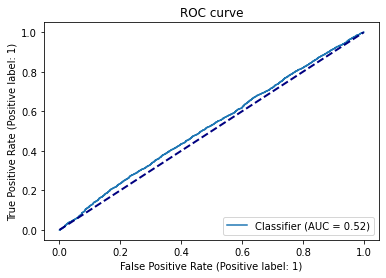

In [8]:
from apt.risk.data_assessment.dataset_attack_membership_knn_probabilities import \
    DatasetAttackConfigMembershipKnnProbabilities, DatasetAttackMembershipKnnProbabilities

dataset_name = "nursery_kde"

config_g = DatasetAttackConfigMembershipKnnProbabilities(use_batches=True,
                                                          generate_plot=True)
attack_g = DatasetAttackMembershipKnnProbabilities(original_data_members,
                                                    original_data_non_members,
                                                    synthetic_data,
                                                    config_g,
                                                    dataset_name)

score_g = attack_g.assess_privacy()
score_g

### DatasetAttackWholeDatasetKnnDistance
Run the privacy risk assessment for synthetic datasets based on distances of synthetic data records from
members (training set) and non-members (holdout set). 

The privacy risk measure is the share of synthetic
records closer to the training than the holdout dataset.

In [9]:
from apt.risk.data_assessment.dataset_attack_whole_dataset_knn_distance import \
    DatasetAttackConfigWholeDatasetKnnDistance, DatasetAttackWholeDatasetKnnDistance
    
config_h = DatasetAttackConfigWholeDatasetKnnDistance(use_batches=False)
attack_h = DatasetAttackWholeDatasetKnnDistance(original_data_members, original_data_non_members,
                                                synthetic_data, config_h, dataset_name)

score_h = attack_h.assess_privacy()
score_h

DatasetAttackScoreWholeDatasetKnnDistance(dataset_name='nursery_kde', risk_score=0.755, result=None, share=0.755, assessment_type='WholeDatasetKnnDistance')